In [1]:
import torch
import numpy as np
import pickle
import cv2
import matplotlib.pyplot as plt
import pytorch3d
import pytorch3d.io
import json
import random
import pickle
import matplotlib.pyplot as plt
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene

In [ ]:
# Code to get depth:

# raster_settings = RasterizationSettings(
#         image_size=image_size, blur_radius=0.0, faces_per_pixel=1, 
#         perspective_correct=True,
#         bin_size=0
#     )
# rasterizer=MeshRasterizer(raster_settings=raster_settings)
# fragments = rasterizer(meshes, cameras=cameras)
# depth = fragments.zbuf[0].cpu().numpy()

In [21]:
mesh_path = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260'
depth_path1 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_0_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'
depth_path2 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_1_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'
depth_path3 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_2_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'
depth_path4 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_3_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'
depth_path5 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_4_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'
depth_path6 = './pose__01_11_gender_m_shape_624_texture_nongrey_male_0364_time_1260_angle_5_x_0.26754171723194514_y_-0.18489293568114512_z_2.424635552723259.pkl'

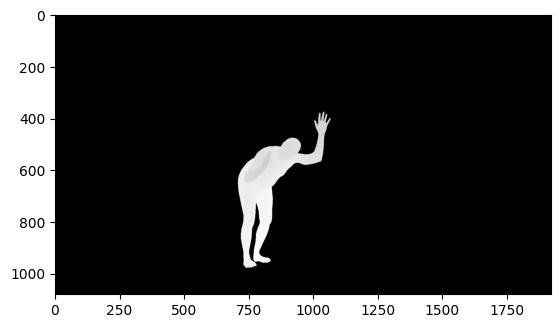

In [25]:
with open(depth_path1, 'rb') as handle:
    img1 = pickle.load(handle)
    
with open(depth_path2, 'rb') as handle:
    img2 = pickle.load(handle)
    
with open(depth_path3, 'rb') as handle:
    img3 = pickle.load(handle)
    
with open(depth_path4, 'rb') as handle:
    img4 = pickle.load(handle)
    
with open(depth_path5, 'rb') as handle:
    img5 = pickle.load(handle)
    
with open(depth_path6, 'rb') as handle:
    img6 = pickle.load(handle)
    
img_list = [img1, img2, img3, img4, img5, img6]
plt.imshow(img, cmap='gray')

In [26]:
R_list = [
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([90,180,135])/180*np.pi, convention='XYZ'),
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([100,180,180])/180*np.pi, convention='XYZ'),
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([90,180,300])/180*np.pi, convention='XYZ'),
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([90,180,360])/180*np.pi, convention='XYZ'),
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([90,180,30])/180*np.pi, convention='XYZ'),
    pytorch3d.transforms.euler_angles_to_matrix(torch.Tensor([80,180,70])/180*np.pi, convention='XYZ'),
]

In [27]:
new_vertices, new_face_props, new_text_props = pytorch3d.io.load_obj(mesh_path)

/home/ashwinvaswani/anaconda3/envs/pytorch3d_prohmr/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:542: UserWarning:

No mtl file provided



In [38]:
device = torch.device("cuda:1")
aspect_ratio = 1920 / 1080

x, y, z = 0, 0, 0
T = torch.tensor([0.26754171723194514+x, -0.18489293568114512+y, 2.424635552723259+z]).float().to(device)

out_list = []
for i in range(6):
    R = R_list[i]
    cameras = pytorch3d.renderer.FoVPerspectiveCameras(
                        R=R.T.unsqueeze(0), T=T.unsqueeze(0), fov=60, device=device, aspect_ratio=aspect_ratio, 
                    )
    cull=img[img>0].min()
    dist = torch.distributions.uniform.Uniform(-1, 1)
    grid = dist.sample((1, 1, 2073600, 2)).to(device)
    depth_sample = torch.nn.functional.grid_sample(torch.Tensor(img_list[i]).unsqueeze(0).permute(0, 3, 1, 2).to(device), grid, align_corners=True)
    uv_depth = torch.cat([grid[0, 0]*-1, depth_sample[0, 0, 0].unsqueeze(-1)], dim=1)
    xyz_unproj_world = cameras.unproject_points(uv_depth, world_coordinates=True)
    # xyz_unproj_world = xyz_unproj_world[uv_depth[:,-1]>cull]
    out_list.append(xyz_unproj_world)

In [ ]:
# pc_out = []
# for i in range(6):
#     xyz_unproj_world = out_list[i]
#     xyz_unproj_world = torch.Tensor(xyz_unproj_world).to(device)

#     if len(xyz_unproj_world.shape) < 3:
#         xyz_unproj_world = xyz_unproj_world.unsqueeze(0)

#     rgbs = torch.ones_like(xyz_unproj_world).to(device)
#     if len(rgbs.shape) < 3:
#         rgbs = rgbs.unsqueeze(0)
        
#     pc_out.append(pytorch3d.structures.Pointclouds(points=xyz_unproj_world, features=rgbs*0).to(device))

# point_cloud_gt = pytorch3d.structures.Pointclouds(points=new_vertices.unsqueeze(0), features=torch.ones_like(new_vertices).unsqueeze(0)).to(device)

# fig2 = plot_scene({
#     "figure": {
#         "pc_0": pc_out[0],
#         "pc_1": pc_out[1],
#         "pc_2": pc_out[2],
#         "pc_3": pc_out[3],
#         "pc_4": pc_out[4],
#         "pc_5": pc_out[5],
#         "pointcloud_gt": point_cloud_gt,
#         "Camera": cameras,
#     }
# },
#     xaxis={"backgroundcolor":"rgb(200, 200, 230)"},
#     yaxis={"backgroundcolor":"rgb(230, 200, 200)"},
#     zaxis={"backgroundcolor":"rgb(200, 230, 200)"}, 
#     axis_args=AxisArgs(showgrid=True))
# fig2.show()